# Simulation

In [570]:
#
from util import *
import random
from config import *
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

#### Action Set

In [571]:
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- not_sure: 10
- multiple_choice: 6
- closing: 5
- inform: 1
- confirm_question: 2


### slot set

In [572]:
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- closing: 3
- movie_series: 11
- greeting: 9
- other: 17
- critic_rating: 4


### movie dic: info about movie

In [573]:
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 803: {'city': 'sappington', 'theater': 'wehrenberg ronnies 20 cine and imax', 'zip': '63126', 'distanceconstraints': 'near here', 'critic_rating': 'nice', 'state': 'mo', 'other': 'english and chinese subtitles', 'starttime': '7:20', 'genre': 'romantic', 'moviename': 'how to be single'}


#### word dictionary

# Language Generator (pretrained)

In [574]:
class Nlg():
    def __init__(self):
        pass
    
    def load_nlg_model(self, model_path):
        """ 
        load the trained NLG model 
        """  
        model_params = pickle.load(open(model_path, 'rb'), encoding='latin1')
        hidden_size = model_params['model']['Wd'].shape[0]
        output_size = model_params['model']['Wd'].shape[1]
        if model_params['params']['model'] == 'lstm_tanh': # lstm_tanh
            diaact_input_size = model_params['model']['Wah'].shape[0]
            input_size = model_params['model']['WLSTM'].shape[0] - hidden_size - 1
            rnnmodel = lstm_decoder_tanh(diaact_input_size, input_size, hidden_size, output_size)
        
        rnnmodel.model = copy.deepcopy(model_params['model'])
        model_params['params']['beam_size'] = NlgConfig.beam_size
        
        self.model = rnnmodel
        self.word_dict = copy.deepcopy(model_params['word_dict'])
        self.template_word_dict = copy.deepcopy(model_params['template_word_dict'])
        self.slot_dict = copy.deepcopy(model_params['slot_dict'])
        self.act_dict = copy.deepcopy(model_params['act_dict'])
        self.inverse_word_dict = {self.template_word_dict[k]:k for k in self.template_word_dict.keys()}
        self.params = copy.deepcopy(model_params['params'])
    
    def load_predefine_act_nl_pairs(self, path):
        """ 
        Load some pre-defined Dia_Act&NL Pairs from file 
        """
        self.diaact_nl_pairs = json.load(open(path, 'r'), encoding="latin1")
        
    def convert_diaact_to_nl(self, dia_act, turn_msg):
        """ 
        Convert Dia_Act into NL: Rule + Model 
        """
        
        sentence = ""
        boolean_in = False
        
        # remove I do not care slot in task(complete)
        if dia_act['diaact'] == 'inform' and 'taskcomplete' in dia_act['inform_slots'].keys() and dia_act['inform_slots']['taskcomplete'] != NlgConfig.NO_VALUE_MATCH:
            inform_slot_set = list(dia_act['inform_slots'].keys())
            for slot in inform_slot_set:
                if dia_act['inform_slots'][slot] == NlgConfig.I_DO_NOT_CARE: del dia_act['inform_slots'][slot]
        
        if dia_act['diaact'] in self.diaact_nl_pairs['dia_acts'].keys():
            for ele in self.diaact_nl_pairs['dia_acts'][dia_act['diaact']]:
                if set(ele['inform_slots']) == set(dia_act['inform_slots'].keys()) and set(ele['request_slots']) == set(dia_act['request_slots'].keys()):
                    sentence = self.diaact_to_nl_slot_filling(dia_act, ele['nl'][turn_msg])
                    boolean_in = True
                    break
        
        if dia_act['diaact'] == 'inform' and 'taskcomplete' in dia_act['inform_slots'].keys() and dia_act['inform_slots']['taskcomplete'] == NlgConfig.NO_VALUE_MATCH:
            sentence = "Oh sorry, there is no ticket available."
        
        if boolean_in == False: sentence = self.translate_diaact(dia_act)
        return sentence
    
    
    def diaact_to_nl_slot_filling(self, dia_act, template_sentence):
        """ Replace the slots with its values """
        
        sentence = template_sentence
        counter = 0
        for slot in dia_act['inform_slots'].keys():
            slot_val = dia_act['inform_slots'][slot]
            if slot_val == NlgConfig.NO_VALUE_MATCH:
                sentence = slot + " is not available!"
                break
            elif slot_val == NlgConfig.I_DO_NOT_CARE:
                counter += 1
                sentence = sentence.replace("$"+slot+"$", "", 1)
                continue
            
            
        
        if counter > 0 and counter == len(dia_act['inform_slots']):
            sentence = NlgConfig.I_DO_NOT_CARE
        
        return sentence
    
    def post_process(self, pred_template, slot_val_dict, slot_dict):
        """ fill the slot in the template sentence """
        
        sentence = pred_template
        suffix = "_PLACEHOLDER"
        
        for slot in slot_val_dict.keys():
            slot_vals = slot_val_dict[slot]
            slot_placeholder = slot + suffix
            if slot == 'result' or slot == 'numberofpeople': continue
            if slot_vals == NlgConfig.NO_VALUE_MATCH: continue
            tmp_sentence = sentence.replace(slot_placeholder, slot_vals, 1)
            sentence = tmp_sentence
                
        if 'numberofpeople' in slot_val_dict.keys():
            slot_vals = slot_val_dict['numberofpeople']
            slot_placeholder = 'numberofpeople' + suffix
            tmp_sentence = sentence.replace(slot_placeholder, slot_vals, 1)
            sentence = tmp_sentence
    
        for slot in slot_dict.keys():
            slot_placeholder = slot + suffix
            tmp_sentence = sentence.replace(slot_placeholder, '')
            sentence = tmp_sentence
            
        return sentence
    
    
    def translate_diaact(self, dia_act):
        """ prepare the diaact into vector representation, and generate the sentence by Model """
        
        word_dict = self.word_dict
        template_word_dict = self.template_word_dict
        act_dict = self.act_dict
        slot_dict = self.slot_dict
        inverse_word_dict = self.inverse_word_dict
    
        act_rep = np.zeros((1, len(act_dict)))
        act_rep[0, act_dict[dia_act['diaact']]] = 1.0
    
        slot_rep_bit = 2
        slot_rep = np.zeros((1, len(slot_dict)*slot_rep_bit)) 
    
        suffix = "_PLACEHOLDER"
        if self.params['dia_slot_val'] == 2 or self.params['dia_slot_val'] == 3:
            word_rep = np.zeros((1, len(template_word_dict)))
            words = np.zeros((1, len(template_word_dict)))
            words[0, template_word_dict['s_o_s']] = 1.0
        else:
            word_rep = np.zeros((1, len(word_dict)))
            words = np.zeros((1, len(word_dict)))
            words[0, word_dict['s_o_s']] = 1.0
    
        for slot in dia_act['inform_slots'].keys():
            slot_index = slot_dict[slot]
            slot_rep[0, slot_index*slot_rep_bit] = 1.0
        
            for slot_val in dia_act['inform_slots'][slot]:
                if self.params['dia_slot_val'] == 2:
                    slot_placeholder = slot + suffix
                    if slot_placeholder in template_word_dict.keys():
                        word_rep[0, template_word_dict[slot_placeholder]] = 1.0
                elif self.params['dia_slot_val'] == 1:
                    if slot_val in word_dict.keys():
                        word_rep[0, word_dict[slot_val]] = 1.0
                    
        for slot in dia_act['request_slots'].keys():
            slot_index = slot_dict[slot]
            slot_rep[0, slot_index*slot_rep_bit + 1] = 1.0
    
        if self.params['dia_slot_val'] == 0 or self.params['dia_slot_val'] == 3:
            final_representation = np.hstack([act_rep, slot_rep])
        else: # dia_slot_val = 1, 2
            final_representation = np.hstack([act_rep, slot_rep, word_rep])
    
        dia_act_rep = {}
        dia_act_rep['diaact'] = final_representation
        dia_act_rep['words'] = words
    
        #pred_ys, pred_words = nlg_model['model'].forward(inverse_word_dict, dia_act_rep, nlg_model['params'], predict_model=True)
        pred_ys, pred_words = self.model.beam_forward(inverse_word_dict, dia_act_rep, self.params, predict_model=True)
        pred_sentence = ' '.join(pred_words[:-1])
        sentence = self.post_process(pred_sentence, dia_act['inform_slots'], slot_dict)
            
        return sentence

In [575]:
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [576]:
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
print(params.keys())
print(params['split_method'])
print(params['write_model_dir'])

dict_keys(['grad_clip', 'dia_slot_val', 'reg_cost', 'data_path', 'save_check_point', 'slot_rep', 'max_epochs', 'sdgtype', 'init_rnn', 'cv_fold', 'write_model_dir', 'valid_test', 'pretrained_model_path', 'check_point', 'decay_rate', 'feed_recurrence', 'hidden_size', 'activation_func', 'momentum', 'learning_rate', 'batch_size', 'act_set', 'smooth_eps', 'split_method', 'slot_set', 'eva_metric', 'model'])
1
.\checkpoints\template\07102016\


# User Simulator

### goal

In [577]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [578]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [579]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.05
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

In [580]:
class UserSimulator:
    def set_nlg_model(self, nlg_model):
        self.nlg_model = nlg_model  
    
    def set_nlu_model(self, nlu_model):
        self.nlu_model = nlu_model
    
    def add_nl_to_action(self, user_action):
        """ 
        Add NL to User Dia_Act 
        """
        
        user_nlg_sentence = self.nlg_model.convert_diaact_to_nl(user_action, 'usr')
        user_action['nl'] = user_nlg_sentence
        
        if self.act_level == 1:
            user_nlu_res = self.nlu_model.generate_dia_act(user_action['nl']) # NLU
            if user_nlu_res != None:
                #user_nlu_res['diaact'] = user_action['diaact'] # or not?
                user_action.update(user_nlu_res)
    

In [581]:
class RuleSimulator(UserSimulator):
    """ 
    A rule-based user simulator for testing dialog policy 
    """
    def __init__(self, movie_dict = None, act_set = None, slot_set = None, start_set = None, params = None):
        self.movie_dict = movie_dict
        self.act_set = act_set
        self.slot_set = slot_set
        self.start_set = start_set
        self.max_turn = params['max_turn']
        self.slot_err_prob = params['slot_err_prob']
        self.slot_err_mode = params['slot_err_mode']
        self.intent_err_prob = params['intent_err_prob']
        self.run_mode = params['run_mode']
        self.act_level = params['act_level']
        self.learn_phase = params['learn_phase']
     
    
    def _sample_goal(self, goal_set):
        return np.random.choice(self.start_set[self.learn_phase])
        
    def init_episode(self):
        """ 
        Initialize a new episode (dialog) 
            state['hist_slots']: keeps all the informed_slots
            state['rest_slots']: keep all the slots (which is still in the stack yet)
        """
        self.state = {}
        self.state['hist_slots'] = {}
        self.state['inform_slots'] = {}
        self.state['request_slots'] = {}
        self.state['rest_slots'] = []
        self.state['turn'] = 0
        self.episode_done = False
        self.status = UserSimulatorConfig.NO_OUTCOME_YET
        
        self.goal = self._sample_goal(self.start_set)
        self.goal['request_slots']['ticket'] = 'UNK'
        self.constraint_check = UserConfig.CONSTRAINT_CHECK_FAILURE
        
        # sample first action
        user_action = self._sample_action()
        assert (self.episode_done != 1),' but we just started'
        return user_action

    def _sample_action(self):
        """ 
        randomly sample a start action based on user goal 
        """
        
        self.state['diaact'] = random.choice(list(UserConfig.start_dia_acts.keys()))
        
        # "sample" informed slots
        if len(self.goal['inform_slots']) > 0:
            known_slot = random.choice(list(self.goal['inform_slots'].keys()))
            self.state['inform_slots'][known_slot] = self.goal['inform_slots'][known_slot]

            if 'moviename' in self.goal['inform_slots'].keys(): # 'moviename' must appear in the first user turn
                self.state['inform_slots']['moviename'] = self.goal['inform_slots']['moviename']
                
            for slot in self.goal['inform_slots'].keys():
                if known_slot == slot or slot == 'moviename': continue
                self.state['rest_slots'].append(slot)
        
        self.state['rest_slots'].extend(self.goal['request_slots'].keys())
        
        # "sample" a requested slot
        request_slot_set = list(self.goal['request_slots'].keys())
        request_slot_set.remove('ticket')
        if len(request_slot_set) > 0:
            request_slot = random.choice(request_slot_set)
        else:
            request_slot = 'ticket'
        self.state['request_slots'][request_slot] = 'UNK'
        
        if len(self.state['request_slots']) == 0:
            self.state['diaact'] = 'inform'

        if (self.state['diaact'] in ['thanks','closing']): self.spisode_done = True
        else: self.spisode_done = False 

        sample_action = {}
        sample_action['diaact'] = self.state['diaact']
        sample_action['inform_slots'] = self.state['inform_slots']
        sample_action['request_slots'] = self.state['request_slots']
        sample_action['turn'] = self.state['turn']
        
        self.add_nl_to_action(sample_action)
        return sample_action
    
        
        
    def corrupt(self, user_action):
        """ Randomly corrupt an action with error probs (slot_err_probability and slot_err_mode) on Slot and Intent (intent_err_probability). """
        
        for slot in user_action['inform_slots'].keys():
            slot_err_prob_sample = random.random()
            if slot_err_prob_sample < self.slot_err_prob: # add noise for slot level
                if self.slot_err_mode == 0: # replace the slot_value only
                    if slot in self.movie_dict.keys(): user_action['inform_slots'][slot] = random.choice(self.movie_dict[slot])
                elif self.slot_err_mode == 1: # combined
                    slot_err_random = random.random()
                    if slot_err_random <= 0.33:
                        if slot in self.movie_dict.keys(): user_action['inform_slots'][slot] = random.choice(self.movie_dict[slot])
                    elif slot_err_random > 0.33 and slot_err_random <= 0.66:
                        del user_action['inform_slots'][slot]
                        random_slot = random.choice(self.movie_dict.keys())
                        user_action[random_slot] = random.choice(self.movie_dict[random_slot])
                    else:
                        del user_action['inform_slots'][slot]
                elif self.slot_err_mode == 2: #replace slot and its values
                    del user_action['inform_slots'][slot]
                    random_slot = random.choice(self.movie_dict.keys())
                    user_action[random_slot] = random.choice(self.movie_dict[random_slot])
                elif self.slot_err_mode == 3: # delete the slot
                    del user_action['inform_slots'][slot]   
        
    def next(self, system_action):
        """ Generate next User Action based on last System Action """
        
        self.state['turn'] += 2
        self.spisode_done = False
        self.dialog_status = UserSimulatorConfig.NO_OUTCOME_YET
        
        sys_act = system_action['diaact']
        
        if (self.max_turn > 0 and self.state['turn'] > self.max_turn):
            self.dialog_status = DlgManagerConfig.FAILED_DIALOG
            self.spisode_done = True
            self.state['diaact'] = "closing"
        else:
            self.state['hist_slots'].update(self.state['inform_slots'])
            self.state['inform_slots'].clear()

            if sys_act == "inform":
                self.response_inform(system_action)
            elif sys_act == "multiple_choice":
                self.response_multiple_choice(system_action)
            elif sys_act == "request":
                self.response_request(system_action) 
            elif sys_act == "thanks":
                self.response_thanks(system_action)
            elif sys_act == "confirm_answer":
                self.response_confirm_answer(system_action)
            elif sys_act == "closing":
                self.spisode_done = True
                self.state['diaact'] = "thanks"

        self.corrupt(self.state)
        
        response_action = {}
        response_action['diaact'] = self.state['diaact']
        response_action['inform_slots'] = self.state['inform_slots']
        response_action['request_slots'] = self.state['request_slots']
        response_action['turn'] = self.state['turn']
        response_action['nl'] = ""
        
        # add NL to dia_act
        self.add_nl_to_action(response_action)                       
        return response_action, self.spisode_done, self.dialog_status
    
    def response_confirm_answer(self, system_action):
        """ Response for Confirm_Answer (System Action) """
    
        if len(self.state['rest_slots']) > 0:
            request_slot = random.choice(self.state['rest_slots'])

            if request_slot in self.goal['request_slots'].keys():
                self.state['diaact'] = "request"
                self.state['request_slots'][request_slot] = "UNK"
            elif request_slot in self.goal['inform_slots'].keys():
                self.state['diaact'] = "inform"
                self.state['inform_slots'][request_slot] = self.goal['inform_slots'][request_slot]
                if request_slot in self.state['rest_slots']:
                    self.state['rest_slots'].remove(request_slot)
        else:
            self.state['diaact'] = "thanks"
            
    def response_thanks(self, system_action):
        """ Response for Thanks (System Action) """
        
        self.spisode_done = True
        self.dialog_status = DlgManagerConfig.SUCCESS_DIALOG

        request_slot_set = copy.deepcopy(list(self.state['request_slots'].keys()))
        if 'ticket' in request_slot_set:
            request_slot_set.remove('ticket')
        rest_slot_set = copy.deepcopy(self.state['rest_slots'])
        if 'ticket' in rest_slot_set:
            rest_slot_set.remove('ticket')

        if len(request_slot_set) > 0 or len(rest_slot_set) > 0:
            self.dialog_status = DlgManagerConfig.FAILED_DIALOG

        for info_slot in self.state['hist_slots'].keys():
            if self.state['hist_slots'][info_slot] == NlgConfig.NO_VALUE_MATCH:
                self.dialog_status = DlgManagerConfig.FAILED_DIALOG
            if info_slot in self.goal['inform_slots'].keys():
                if self.state['hist_slots'][info_slot] != self.goal['inform_slots'][info_slot]:
                    self.dialog_status = DlgManagerConfig.FAILED_DIALOG

        if 'ticket' in system_action['inform_slots'].keys():
            if system_action['inform_slots']['ticket'] == DlgManagerConfig.NO_VALUE_MATCH:
                self.dialog_status = DlgManagerConfig.FAILED_DIALOG
                
        if self.constraint_check == DlgManagerConfig.CONSTRAINT_CHECK_FAILURE:
            self.dialog_status = DlgManagerConfig.FAILED_DIALOG
    
    def response_request(self, system_action):
        """ Response for Request (System Action) """
        
        if len(system_action['request_slots'].keys()) > 0:
            slot = list(system_action['request_slots'].keys())[0] # only one slot
            if slot in self.goal['inform_slots'].keys(): # request slot in user's constraints  #and slot not in self.state['request_slots'].keys():
                self.state['inform_slots'][slot] = self.goal['inform_slots'][slot]
                self.state['diaact'] = "inform"
                if slot in self.state['rest_slots']: self.state['rest_slots'].remove(slot)
                if slot in self.state['request_slots'].keys(): del self.state['request_slots'][slot]
                self.state['request_slots'].clear()
            elif slot in self.goal['request_slots'].keys() and slot not in self.state['rest_slots'] and slot in self.state['hist_slots'].keys(): # the requested slot has been answered
                self.state['inform_slots'][slot] = self.state['hist_slots'][slot]
                self.state['request_slots'].clear()
                self.state['diaact'] = "inform"
            elif slot in self.goal['request_slots'].keys() and slot in self.state['rest_slots']: # request slot in user's goal's request slots, and not answered yet
                self.state['diaact'] = "request" # "confirm_question"
                self.state['request_slots'][slot] = "UNK"

                ########################################################################
                # Inform the rest of informable slots
                ########################################################################
                for info_slot in self.state['rest_slots']:
                    if info_slot in self.goal['inform_slots'].keys():
                        self.state['inform_slots'][info_slot] = self.goal['inform_slots'][info_slot]

                for info_slot in self.state['inform_slots'].keys():
                    if info_slot in self.state['rest_slots']:
                        self.state['rest_slots'].remove(info_slot)
            else:
                if len(self.state['request_slots']) == 0 and len(self.state['rest_slots']) == 0:
                    self.state['diaact'] = "thanks"
                else:
                    self.state['diaact'] = "inform"
                self.state['inform_slots'][slot] = NlgConfig.I_DO_NOT_CARE
        else: # this case should not appear
            if len(self.state['rest_slots']) > 0:
                random_slot = random.choice(self.state['rest_slots'])
                if random_slot in self.goal['inform_slots'].keys():
                    self.state['inform_slots'][random_slot] = self.goal['inform_slots'][random_slot]
                    self.state['rest_slots'].remove(random_slot)
                    self.state['diaact'] = "inform"
                elif random_slot in self.goal['request_slots'].keys():
                    self.state['request_slots'][random_slot] = self.goal['request_slots'][random_slot]
                    self.state['diaact'] = "request"

    def response_multiple_choice(self, system_action):
        """ Response for Multiple_Choice (System Action) """
        
        slot = system_action['inform_slots'].keys()[0]
        if slot in self.goal['inform_slots'].keys():
            self.state['inform_slots'][slot] = self.goal['inform_slots'][slot]
        elif slot in self.goal['request_slots'].keys():
            self.state['inform_slots'][slot] = random.choice(system_action['inform_slots'][slot])

        self.state['diaact'] = "inform"
        if slot in self.state['rest_slots']: self.state['rest_slots'].remove(slot)
        if slot in self.state['request_slots'].keys(): del self.state['request_slots'][slot]
        
    def response_inform(self, system_action):
        """ Response for Inform (System Action) """
        
        if 'taskcomplete' in system_action['inform_slots'].keys(): # check all the constraints from agents with user goal
            self.state['diaact'] = "thanks"
            #if 'ticket' in self.state['rest_slots']: self.state['request_slots']['ticket'] = 'UNK'
            self.constraint_check = UserConfig.CONSTRAINT_CHECK_SUCCESS
                    
            if system_action['inform_slots']['taskcomplete'] == NlgConfig.NO_VALUE_MATCH:
                self.state['hist_slots']['ticket'] = NlgConfig.NO_VALUE_MATCH
                if 'ticket' in self.state['rest_slots']: self.state['rest_slots'].remove('ticket')
                if 'ticket' in self.state['request_slots'].keys(): del self.state['request_slots']['ticket']
                    
            for slot in self.goal['inform_slots'].keys():
                #  Deny, if the answers from agent can not meet the constraints of user
                if slot not in system_action['inform_slots'].keys() or (self.goal['inform_slots'][slot].lower() != system_action['inform_slots'][slot].lower()):
                    self.state['diaact'] = "deny"
                    self.state['request_slots'].clear()
                    self.state['inform_slots'].clear()
                    self.constraint_check = UserConfig.CONSTRAINT_CHECK_FAILURE
                    break
        else:
            for slot in system_action['inform_slots'].keys():
                self.state['hist_slots'][slot] = system_action['inform_slots'][slot]
                        
                if slot in self.goal['inform_slots'].keys():
                    if system_action['inform_slots'][slot] == self.goal['inform_slots'][slot]:
                        if slot in self.state['rest_slots']: self.state['rest_slots'].remove(slot)
                                
                        if len(self.state['request_slots']) > 0:
                            self.state['diaact'] = "request"
                        elif len(self.state['rest_slots']) > 0:
                            rest_slot_set = copy.deepcopy(self.state['rest_slots'])
                            if 'ticket' in rest_slot_set:
                                rest_slot_set.remove('ticket')

                            if len(rest_slot_set) > 0:
                                inform_slot = random.choice(rest_slot_set) # self.state['rest_slots']
                                if inform_slot in self.goal['inform_slots'].keys():
                                    self.state['inform_slots'][inform_slot] = self.goal['inform_slots'][inform_slot]
                                    self.state['diaact'] = "inform"
                                    self.state['rest_slots'].remove(inform_slot)
                                elif inform_slot in self.goal['request_slots'].keys():
                                    self.state['request_slots'][inform_slot] = 'UNK'
                                    self.state['diaact'] = "request"
                            else:
                                self.state['request_slots']['ticket'] = 'UNK'
                                self.state['diaact'] = "request"
                        else: # how to reply here?
                            self.state['diaact'] = "thanks" # replies "closing"? or replies "confirm_answer"
                    else: # != value  Should we deny here or ?
                        ########################################################################
                        # TODO When agent informs(slot=value), where the value is different with the constraint in user goal, Should we deny or just inform the correct value?
                        ########################################################################
                        self.state['diaact'] = "inform"
                        self.state['inform_slots'][slot] = self.goal['inform_slots'][slot]
                        if slot in self.state['rest_slots']: self.state['rest_slots'].remove(slot)
                else:
                    if slot in self.state['rest_slots']:
                        self.state['rest_slots'].remove(slot)
                    if slot in self.state['request_slots'].keys():
                        del self.state['request_slots'][slot]

                    if len(self.state['request_slots']) > 0:
                        request_set = list(self.state['request_slots'].keys())
                        if 'ticket' in request_set:
                            request_set.remove('ticket')

                        if len(request_set) > 0:
                            request_slot = random.choice(request_set)
                        else:
                            request_slot = 'ticket'

                        self.state['request_slots'][request_slot] = "UNK"
                        self.state['diaact'] = "request"
                    elif len(self.state['rest_slots']) > 0:
                        rest_slot_set = copy.deepcopy(self.state['rest_slots'])
                        if 'ticket' in rest_slot_set:
                            rest_slot_set.remove('ticket')

                        if len(rest_slot_set) > 0:
                            inform_slot = random.choice(rest_slot_set) #self.state['rest_slots']
                            if inform_slot in self.goal['inform_slots'].keys():
                                self.state['inform_slots'][inform_slot] = self.goal['inform_slots'][inform_slot]
                                self.state['diaact'] = "inform"
                                self.state['rest_slots'].remove(inform_slot)
                                        
                                if 'ticket' in self.state['rest_slots']:
                                    self.state['request_slots']['ticket'] = 'UNK'
                                    self.state['diaact'] = "request"
                            elif inform_slot in self.goal['request_slots'].keys():
                                self.state['request_slots'][inform_slot] = self.goal['request_slots'][inform_slot]
                                self.state['diaact'] = "request"
                        else:
                            self.state['request_slots']['ticket'] = 'UNK'
                            self.state['diaact'] = "request"
                    else:
                        self.state['diaact'] = "thanks" # or replies "confirm_answer"

### a movie dictionary for user simulator - slot:possible values

In [582]:
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- genre: ['comedy', 'comedies', 'kid', 'action', 'violence', 'superhero', 'romance', 'thriller', 'drama', 'family friendly', 'funny', 'kids', 'scary', 'horror', 'showing', 'romantic comedies', 'romantic comedy', 'adult comedy', 'romantic', 'drama/romance', 'foreign', 'superhero movie', 'dramas', 'animated', 'thriller science fiction', 'super great day', 'comedies)', 'not live action', 'date night:', 'sci-fi', 'Action/Adventure Sci-Fi/Fantasy']


###  Create a User

In [583]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# State Tracker

## Knowledge Base Helper

In [584]:
from collections import defaultdict

class KBHelper:
    """ 
    An assistant to fill in values for the agent (which knows about slots of values) 
    """
    
    def __init__(self, movie_dictionary):
        self.movie_dictionary = movie_dictionary
        self.cached_kb = defaultdict(list)
        self.cached_kb_slot = defaultdict(list)


    def fill_inform_slots(self, inform_slots_to_be_filled, current_slots):
        """ 
        Takes unfilled inform slots and current_slots, returns dictionary of filled informed slots (with values)

        Arguments:
        inform_slots_to_be_filled   --  Something that looks like {starttime:None, theater:None} where starttime and theater are slots that the agent needs filled
        current_slots               --  Contains a record of all filled slots in the conversation so far - for now, just use current_slots['inform_slots'] which is a dictionary of the already filled-in slots

        Returns:
        filled_in_slots             --  A dictionary of form {slot1:value1, slot2:value2} for each sloti in inform_slots_to_be_filled
        """
        
        kb_results = self.available_results_from_kb(current_slots)
        if NlgConfig.auto_suggest == 1:
            print('Number of movies in KB satisfying current constraints: ', len(kb_results))

        filled_in_slots = {}
        if 'taskcomplete' in inform_slots_to_be_filled.keys():
            filled_in_slots.update(current_slots['inform_slots'])
        
        for slot in inform_slots_to_be_filled.keys():
            if slot == 'numberofpeople':
                if slot in current_slots['inform_slots'].keys():
                    filled_in_slots[slot] = current_slots['inform_slots'][slot]
                elif slot in inform_slots_to_be_filled.keys():
                    filled_in_slots[slot] = inform_slots_to_be_filled[slot]
                continue

            if slot == 'ticket' or slot == 'taskcomplete':
                filled_in_slots[slot] = NlgConfig.TICKET_AVAILABLE if len(kb_results)>0 else NlgConfig.NO_VALUE_MATCH
                continue
            
            if slot == 'closing': continue

            ####################################################################
            #   Grab the value for the slot with the highest count and fill it
            ####################################################################
            values_dict = self.available_slot_values(slot, kb_results)

            values_counts = [(v, values_dict[v]) for v in values_dict.keys()]
            if len(values_counts) > 0:
                filled_in_slots[slot] = sorted(values_counts, key = lambda x: -x[1])[0][0]
            else:
                filled_in_slots[slot] = NlgConfig.NO_VALUE_MATCH #"NO VALUE MATCHES SNAFU!!!"
           
        return filled_in_slots


    def available_slot_values(self, slot, kb_results):
        """ 
        Return the set of values available for the slot based on the current constraints 
        """
        
        slot_values = {}
        for movie_id in kb_results.keys():
            if slot in kb_results[movie_id].keys():
                slot_val = kb_results[movie_id][slot]
                if slot_val in slot_values.keys():
                    slot_values[slot_val] += 1
                else: slot_values[slot_val] = 1
        return slot_values

    def available_results_from_kb(self, current_slots):
        """ 
        Return the available movies in the movie_kb based on the current constraints 
        """
        
        ret_result = []
        current_slots = current_slots['inform_slots']
        constrain_keys = current_slots.keys()

        constrain_keys = filter(lambda k : k != 'ticket' and \
                                           k != 'numberofpeople' and \
                                           k!= 'taskcomplete' and \
                                           k != 'closing' , constrain_keys)
        constrain_keys = [k for k in constrain_keys if current_slots[k] != NlgConfig.I_DO_NOT_CARE]

        query_idx_keys = frozenset(current_slots.items())
        cached_kb_ret = self.cached_kb[query_idx_keys]

        cached_kb_length = len(cached_kb_ret) if cached_kb_ret != None else -1
        if cached_kb_length > 0:
            return dict(cached_kb_ret)
        elif cached_kb_length == -1:
            return dict([])

        # kb_results = copy.deepcopy(self.movie_dictionary)
        for id in self.movie_dictionary.keys():
            kb_keys = self.movie_dictionary[id].keys()
            if len(set(constrain_keys).union(set(kb_keys)) ^ (set(constrain_keys) ^ set(kb_keys))) == len(
                    constrain_keys):
                match = True
                for idx, k in enumerate(constrain_keys):
                    if str(current_slots[k]).lower() == str(self.movie_dictionary[id][k]).lower():
                        continue
                    else:
                        match = False
                if match:
                    self.cached_kb[query_idx_keys].append((id, self.movie_dictionary[id]))
                    ret_result.append((id, self.movie_dictionary[id]))
        if len(ret_result) == 0:
            self.cached_kb[query_idx_keys] = None

        ret_result = dict(ret_result)
        return ret_result
    
    def available_results_from_kb_for_slots(self, inform_slots):
        """ 
        Return the count statistics for each constraint in inform_slots 
        """
        
        kb_results = {key:0 for key in inform_slots.keys()}
        kb_results['matching_all_constraints'] = 0
        
        query_idx_keys = frozenset(inform_slots.items())
        cached_kb_slot_ret = self.cached_kb_slot[query_idx_keys]

        if len(cached_kb_slot_ret) > 0:
            return cached_kb_slot_ret[0]

        for movie_id in self.movie_dictionary.keys():
            all_slots_match = 1
            for slot in inform_slots.keys():
                if slot == 'ticket' or inform_slots[slot] == NlgConfig.I_DO_NOT_CARE:
                    continue

                if slot in self.movie_dictionary[movie_id].keys():
                    if inform_slots[slot].lower() == self.movie_dictionary[movie_id][slot].lower():
                        kb_results[slot] += 1
                    else:
                        all_slots_match = 0
                else:
                    all_slots_match = 0
            kb_results['matching_all_constraints'] += all_slots_match

        self.cached_kb_slot[query_idx_keys].append(kb_results)
        return kb_results

    
    def database_results_for_agent(self, current_slots):
        """ 
        A dictionary of the number of results matching each current constraint. 
        The agent needs this to decide what to do next. 
        """

        database_results ={} # { date:100, distanceconstraints:60, theater:30,  matching_all_constraints: 5}
        database_results = self.available_results_from_kb_for_slots(current_slots['inform_slots'])
        return database_results
    
    def suggest_slot_values(self, request_slots, current_slots):
        """ 
        Return the suggest slot values 
        """
        
        avail_kb_results = self.available_results_from_kb(current_slots)
        return_suggest_slot_vals = {}
        for slot in request_slots.keys():
            avail_values_dict = self.available_slot_values(slot, avail_kb_results)
            values_counts = [(v, avail_values_dict[v]) for v in avail_values_dict.keys()]
            
            if len(values_counts) > 0:
                return_suggest_slot_vals[slot] = []
                sorted_dict = sorted(values_counts, key = lambda x: -x[1])
                for k in sorted_dict: return_suggest_slot_vals[slot].append(k[0])
            else:
                return_suggest_slot_vals[slot] = []
        
        return return_suggest_slot_vals

In [585]:
class StateTracker:
    """ 
    The state tracker maintains a record of which request slots are filled and which inform slots are filled 
    """
    def __init__(self, act_set, slot_set, movie_dictionary):
        self.act_set = act_set
        self.movie_dictionary = movie_dictionary
        self.slot_set = slot_set
        self.slot_set = slot_set
        self.hist_dic = None
        self.curr_slots = None
        self.init_episode()
        self.act_dim = 10
        self.kb_result_dim = 10
        self.turn_count = 0
        self.kb_helper = KBHelper(movie_dictionary)
    
    def init_episode(self):
        """ 
        Initialize a new episode (dialog), flush the current state and tracked slots 
        """
        self.act_dim = 10
        self.hist_vectors = np.zeros(self.act_dim)
        self.hist_dic = []
        self.turn_count = 0
        self.curr_slots = {}
        self.curr_slots['inform_slots'] = {}
        self.curr_slots['request_slots'] = {}
        self.curr_slots['proposed_slots'] = {}
        self.curr_slots['agt_request_slots'] = {}
    
    def get_state_for_agent(self):
        """ 
        Get the state representatons to send to agent 
        state = 
            {'user_action': self.hist_dic[-1], 
             'curr_slots': self.curr_slots, 
             'kb_results': self.kb_results_for_state()}
        """
        state = {
            "user_action": self.hist_dic[-1],
            "curr_slots":  self.curr_slots,
            "kb_results":  self.kb_helper.database_results_for_agent(self.curr_slots),
            'turn': self.turn_count, 
            'history': self.hist_dic, 
            'agent_action': self.hist_dic[-2] if len(self.hist_dic) > 1 else None
        }
        return copy.deepcopy(state)
    
    def dialog_history_vectors(self):
        """ Return the dialog history (both user and agent actions) in vector representation """
        return self.hist_vec

    def dialog_history_dictionaries(self):
        """  Return the dictionary representation of the dialog history (includes values) """
        return self.hist_dic
    
    
    def update(self, agent_action=None, user_action=None):
        """ 
        Update the state based on the latest action 
        """

        ########################################################################
        #  Make sure that the function was called properly
        ########################################################################
        assert(not (user_action and agent_action))
        assert(user_action or agent_action)

        ########################################################################
        #   Update state to reflect a new action by the agent.
        ########################################################################
        if agent_action:
            
            ####################################################################
            #   Handles the act_slot response (with values needing to be filled)
            ####################################################################
            if agent_action['act_slot_response']:
                response = copy.deepcopy(agent_action['act_slot_response'])
                
                inform_slots = self.kb_helper.fill_inform_slots(response['inform_slots'], self.curr_slots) # TODO this doesn't actually work yet, remove this warning when kb_helper is functional
                agent_action_values = {'turn': self.turn_count, 'speaker': "agent", 'diaact': response['diaact'], 'inform_slots': inform_slots, 'request_slots':response['request_slots']}
                
                agent_action['act_slot_response'].update({'diaact': response['diaact'], 'inform_slots': inform_slots, 'request_slots':response['request_slots'], 'turn':self.turn_count})
                
            elif agent_action['act_slot_value_response']:
                agent_action_values = copy.deepcopy(agent_action['act_slot_value_response'])
                # print("Updating state based on act_slot_value action from agent")
                agent_action_values['turn'] = self.turn_count
                agent_action_values['speaker'] = "agent"
                
            ####################################################################
            #   This code should execute regardless of which kind of agent produced action
            ####################################################################
            for slot in agent_action_values['inform_slots'].keys():
                self.curr_slots['proposed_slots'][slot] = agent_action_values['inform_slots'][slot]
                self.curr_slots['inform_slots'][slot] = agent_action_values['inform_slots'][slot] # add into inform_slots
                if slot in self.curr_slots['request_slots'].keys():
                    del self.curr_slots['request_slots'][slot]

            for slot in agent_action_values['request_slots'].keys():
                if slot not in self.curr_slots['agt_request_slots']:
                    self.curr_slots['agt_request_slots'][slot] = "UNK"

            self.hist_dic.append(agent_action_values)
            current_agent_vector = np.ones((1, self.act_dim))
            self.hist_vectors = np.vstack([self.hist_vectors, current_agent_vector])
                            
        ########################################################################
        #   Update the state to reflect a new action by the user
        ########################################################################
        elif user_action:
            
            ####################################################################
            #   Update the current slots
            ####################################################################
            for slot in user_action['inform_slots'].keys():
                self.curr_slots['inform_slots'][slot] = user_action['inform_slots'][slot]
                if slot in self.curr_slots['request_slots'].keys():
                    del self.curr_slots['request_slots'][slot]

            for slot in user_action['request_slots'].keys():
                if slot not in self.curr_slots['request_slots']:
                    self.curr_slots['request_slots'][slot] = "UNK"
            
            self.hist_vectors = np.vstack([self.hist_vectors, np.zeros((1,self.act_dim))])
            new_move = {'turn': self.turn_count, 'speaker': "user", 'request_slots': user_action['request_slots'], 'inform_slots': user_action['inform_slots'], 'diaact': user_action['diaact']}
            self.hist_dic.append(copy.deepcopy(new_move))

        ########################################################################
        #   This should never happen if the asserts passed
        ########################################################################
        else:
            pass

        ########################################################################
        #   This code should execute after update code regardless of what kind of action (agent/user)
        ########################################################################
        self.turn_count += 1


# Agent

## param

In [586]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 20
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = False
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

pretrained model path = None


## Interface

In [587]:
class Agent:
    """ 
    Parent for all agent classes, defining the interface they must uphold 
    """
    def __init__(self, movie_dict=None, act_set=None, slot_set=None, params=None):
        """ 
        movie_dict      --  This is here now but doesn't belong - the agent doesn't know about movies
        act_set         --  The set of acts. #### Shouldn't this be more abstract? Don't we want our agent to be more broadly usable?
        slot_set        --  The set of available slots
        """
        self.movie_dict = movie_dict
        self.act_set = act_set
        self.slot_set = slot_set
        self.act_cardinality = len(act_set.keys())
        self.slot_cardinality = len(slot_set.keys())
        
        self.epsilon = params['epsilon']
        self.agent_run_mode = params['agent_run_mode']
        self.agent_act_level = params['agent_act_level']
    
    def init_episode(self):
        """ 
        Initialize a new episode. 
        This function is called every time a new episode is run. 
        """
        self.current_action = {}                    #   TODO Changed this variable's name to current_action
        self.current_action['diaact'] = None        #   TODO Does it make sense to call it a state if it has an act? Which act? The Most recent?
        self.current_action['inform_slots'] = {}
        self.current_action['request_slots'] = {}
        
        self.current_action['turn'] = 0
    
    def set_nlg_model(self, nlg_model):
        self.nlg_model = nlg_model  
    
    def set_nlu_model(self, nlu_model):
        self.nlu_model = nlu_model
    
    def register_experience_replay_tuple(self, s_t, a_t, reward, s_tplus1, episode_over):
        """  Register feedback from the environment, to be stored as future training data

        Arguments:
        s_t                 --  The state in which the last action was taken
        a_t                 --  The previous agent action
        reward              --  The reward received immediately following the action
        s_tplus1            --  The state transition following the latest action
        episode_over        --  A boolean value representing whether the this is the final action.

        Returns:
        None
        """
        pass
        
    def state_to_action(self, state, available_actions):
        """ 
        Take the current state and return an action according to the current exploration/exploitation policy

        We define the agents flexibly so that they can either operate on act_slot representations or act_slot_value representations.
        We also define the responses flexibly, returning a dictionary with keys [act_slot_response, act_slot_value_response]. This way the command-line agent can continue to operate with values

        Arguments:
        state      --   A tuple of (history, kb_results) where history is a sequence of previous actions and kb_results contains information on the number of results matching the current constraints.
        user_action         --   A legacy representation used to run the command line agent. We should remove this ASAP but not just yet
        available_actions   --   A list of the allowable actions in the current state

        Returns:
        act_slot_action         --   An action consisting of one act and >= 0 slots as well as which slots are informed vs requested.
        act_slot_value_action   --   An action consisting of acts slots and values in the legacy format. This can be used in the future for training agents that take value into account and interact directly with the database
        """
        print("Agent state_to_action")
        act_slot_response = None
        act_slot_value_response = None
        return({"act_slot_response": act_slot_response, "act_slot_value_response": act_slot_value_response})
    
    def add_nl_to_action(self, agent_action):
        """ Add NL to Agent Dia_Act """
        
        if agent_action['act_slot_response']:
            agent_action['act_slot_response']['nl'] = ""
            user_nlg_sentence = self.nlg_model.convert_diaact_to_nl(agent_action['act_slot_response'], 'agt') #self.nlg_model.translate_diaact(agent_action['act_slot_response']) # NLG
            agent_action['act_slot_response']['nl'] = user_nlg_sentence
        elif agent_action['act_slot_value_response']:
            agent_action['act_slot_value_response']['nl'] = ""
            user_nlg_sentence = self.nlg_model.convert_diaact_to_nl(agent_action['act_slot_value_response'], 'agt') #self.nlg_model.translate_diaact(agent_action['act_slot_value_response']) # NLG
            agent_action['act_slot_response']['nl'] = user_nlg_sentenc

### Request Basics Agent

In [588]:
class RequestBasicsAgent(Agent):
    """ 
    A simple agent to test the system. 
    This agent should simply request all the basic slots and then issue: thanks(). 
    """
    def init_episode(self):
        self.state = {}
        self.state['diaact'] = 'UNK'
        self.state['inform_slots'] = {}
        self.state['request_slots'] = {}
        self.state['turn'] = -1
        self.current_slot_id = 0
        self.request_set = ['moviename', 'starttime', 'city', 'date', 'theater', 'numberofpeople']
        self.phase = 0

    def state_to_action(self, state):
        """ Run current policy on state and produce an action """
        self.state['turn'] += 2
        if self.current_slot_id < len(self.request_set):
            slot = self.request_set[self.current_slot_id]
            self.current_slot_id += 1

            act_slot_response = {}
            act_slot_response['diaact'] = "request"
            act_slot_response['inform_slots'] = {}
            act_slot_response['request_slots'] = {slot: "UNK"}
            act_slot_response['turn'] = self.state['turn']
        elif self.phase == 0:
            act_slot_response = {'diaact': "inform", 'inform_slots': {'taskcomplete': "PLACEHOLDER"}, 'request_slots': {}, 'turn':self.state['turn']}
            self.phase += 1
        elif self.phase == 1:
            act_slot_response = {'diaact': "thanks", 'inform_slots': {}, 'request_slots': {}, 'turn': self.state['turn']}
        else:
            raise Exception("THIS SHOULD NOT BE POSSIBLE (AGENT CALLED IN UNANTICIPATED WAY)")
        return {'act_slot_response': act_slot_response, 'act_slot_value_response': None}

## DQN Alg

In [589]:
class DQN:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.model = {}
        # input-hidden
        self.model['Wxh'] = initWeight(input_size, hidden_size)
        self.model['bxh'] = np.zeros((1, hidden_size))
      
        # hidden-output
        self.model['Wd'] = initWeight(hidden_size, output_size)*0.1
        self.model['bd'] = np.zeros((1, output_size))

        self.update = ['Wxh', 'bxh', 'Wd', 'bd']
        self.regularize = ['Wxh', 'Wd']

        self.step_cache = {}
        

    def getStruct(self):
        return {'model': self.model, 'update': self.update, 'regularize': self.regularize}
    
    
    """Activation Function: Sigmoid, or tanh, or ReLu"""
    def fwdPass(self, Xs, params, **kwargs):
        predict_mode = kwargs.get('predict_mode', False)
        active_func = params.get('activation_func', 'relu')
 
        # input layer to hidden layer
        Wxh = self.model['Wxh']
        bxh = self.model['bxh']
        Xsh = Xs.dot(Wxh) + bxh
        
        hidden_size = self.model['Wd'].shape[0] # size of hidden layer
        H = np.zeros((1, hidden_size)) # hidden layer representation
        
        if active_func == 'sigmoid':
            H = 1/(1+np.exp(-Xsh))
        elif active_func == 'tanh':
            H = np.tanh(Xsh)
        elif active_func == 'relu': # ReLU 
            H = np.maximum(Xsh, 0)
        else: # no activation function
            H = Xsh
                
        # decoder at the end; hidden layer to output layer
        Wd = self.model['Wd']
        bd = self.model['bd']
        Y = H.dot(Wd) + bd
        
        # cache the values in forward pass, we expect to do a backward pass
        cache = {}
        if not predict_mode:
            cache['Wxh'] = Wxh
            cache['Wd'] = Wd
            cache['Xs'] = Xs
            cache['Xsh'] = Xsh
            cache['H'] = H
            
            cache['bxh'] = bxh
            cache['bd'] = bd
            cache['activation_func'] = active_func
            
            cache['Y'] = Y
            
        return Y, cache
    
    def bwdPass(self, dY, cache):
        Wd = cache['Wd']
        H = cache['H']
        Xs = cache['Xs']
        Xsh = cache['Xsh']
        Wxh = cache['Wxh']
 
        active_func = cache['activation_func']
        n,d = H.shape
        
        dH = dY.dot(Wd.transpose())
        # backprop the decoder
        dWd = H.transpose().dot(dY)
        dbd = np.sum(dY, axis=0, keepdims=True)
        
        dXsh = np.zeros(Xsh.shape)
        dXs = np.zeros(Xs.shape)
        
        if active_func == 'sigmoid':
            dH = (H-H**2)*dH
        elif active_func == 'tanh':
            dH = (1-H**2)*dH
        elif active_func == 'relu':
            dH = (H>0)*dH # backprop ReLU
        else:
            dH = dH
              
        # backprop to the input-hidden connection
        dWxh = Xs.transpose().dot(dH)
        dbxh = np.sum(dH, axis=0, keepdims = True)
        
        # backprop to the input
        dXsh = dH
        dXs = dXsh.dot(Wxh.transpose())
        
        return {'Wd': dWd, 'bd': dbd, 'Wxh':dWxh, 'bxh':dbxh}
    
    
    """batch Forward & Backward Pass"""
    def batchForward(self, batch, params, predict_mode = False):
        caches = []
        Ys = []
        for i,x in enumerate(batch):
            Xs = np.array([x['cur_states']], dtype=float)
            
            Y, out_cache = self.fwdPass(Xs, params, predict_mode = predict_mode)
            caches.append(out_cache)
            Ys.append(Y)
           
        # back up information for efficient backprop
        cache = {}
        if not predict_mode:
            cache['caches'] = caches

        return Ys, cache
    
    def batchDoubleForward(self, batch, params, clone_dqn, predict_mode = False):
        caches = []
        Ys = []
        tYs = []
        
        for i,x in enumerate(batch):
            Xs = x[0]
            Y, out_cache = self.fwdPass(Xs, params, predict_mode = predict_mode)
            caches.append(out_cache)
            Ys.append(Y)
            
            tXs = x[3]
            tY, t_cache = clone_dqn.fwdPass(tXs, params, predict_mode = False)
                
            tYs.append(tY)
            
        # back up information for efficient backprop
        cache = {}
        if not predict_mode:
            cache['caches'] = caches

        return Ys, cache, tYs
    
    def batchBackward(self, dY, cache):
        caches = cache['caches']
        
        grads = {}
        for i in range(len(caches)):
            single_cache = caches[i]
            local_grads = self.bwdPass(dY[i], single_cache)
            mergeDicts(grads, local_grads) # add up the gradients wrt model parameters
            
        return grads


    """ cost function, returns cost and gradients for model """
    def costFunc(self, batch, params, clone_dqn):
        regc = params.get('reg_cost', 1e-3)
        gamma = params.get('gamma', 0.9)
        
        # batch forward
        Ys, caches, tYs = self.batchDoubleForward(batch, params, clone_dqn, predict_mode = False)
        
        loss_cost = 0.0
        dYs = []
        for i,x in enumerate(batch):
            Y = Ys[i]
            nY = tYs[i]
            
            action = np.array(x[1], dtype=int)
            reward = np.array(x[2], dtype=float)
            
            n_action = np.nanargmax(nY[0])
            max_next_y = nY[0][n_action]
            
            eposide_terminate = x[4]
            
            target_y = reward
            if eposide_terminate != True: target_y += gamma*max_next_y
            
            pred_y = Y[0][action]
            
            nY = np.zeros(nY.shape)
            nY[0][action] = target_y
            Y = np.zeros(Y.shape)
            Y[0][action] = pred_y
            
            # Cost Function
            loss_cost += (target_y - pred_y)**2
                
            dY = -(nY - Y)
            #dY = np.minimum(dY, 1)
            #dY = np.maximum(dY, -1)
            dYs.append(dY)
        
        # backprop the RNN
        grads = self.batchBackward(dYs, caches)
        
        # add L2 regularization cost and gradients
        reg_cost = 0.0
        if regc > 0:    
            for p in self.regularize:
                mat = self.model[p]
                reg_cost += 0.5*regc*np.sum(mat*mat)
                grads[p] += regc*mat

        # normalize the cost and gradient by the batch size
        batch_size = len(batch)
        reg_cost /= batch_size
        loss_cost /= batch_size
        for k in grads: grads[k] /= batch_size

        out = {}
        out['cost'] = {'reg_cost' : reg_cost, 'loss_cost' : loss_cost, 'total_cost' : loss_cost + reg_cost}
        out['grads'] = grads
        return out


    """ A single batch """
    def singleBatch(self, batch, params, clone_dqn):
        learning_rate = params.get('learning_rate', 0.001)
        decay_rate = params.get('decay_rate', 0.999)
        momentum = params.get('momentum', 0.1)
        grad_clip = params.get('grad_clip', -1e-3)
        smooth_eps = params.get('smooth_eps', 1e-8)
        sdg_type = params.get('sdgtype', 'rmsprop')
        activation_func = params.get('activation_func', 'relu')
        
        for u in self.update:
            if not u in self.step_cache: 
                self.step_cache[u] = np.zeros(self.model[u].shape)
        
        cg = self.costFunc(batch, params, clone_dqn)
        
        cost = cg['cost']
        grads = cg['grads']
        
        # clip gradients if needed
        if activation_func.lower() == 'relu':
            if grad_clip > 0:
                for p in self.update:
                    if p in grads:
                        grads[p] = np.minimum(grads[p], grad_clip)
                        grads[p] = np.maximum(grads[p], -grad_clip)
        
        # perform parameter update
        for p in self.update:
            if p in grads:
                if sdg_type == 'vanilla':
                    if momentum > 0:
                        dx = momentum*self.step_cache[p] - learning_rate*grads[p]
                    else:
                        dx = -learning_rate*grads[p]
                    self.step_cache[p] = dx
                elif sdg_type == 'rmsprop':
                    self.step_cache[p] = self.step_cache[p]*decay_rate + (1.0-decay_rate)*grads[p]**2
                    dx = -(learning_rate*grads[p])/np.sqrt(self.step_cache[p] + smooth_eps)
                elif sdg_type == 'adgrad':
                    self.step_cache[p] += grads[p]**2
                    dx = -(learning_rate*grads[p])/np.sqrt(self.step_cache[p] + smooth_eps)
                    
                self.model[p] += dx

        out = {}
        out['cost'] = cost
        return out
    
    """ prediction """
    def predict(self, Xs, params, **kwargs):
        Ys, caches = self.fwdPass(Xs, params, predict_model=True)
        pred_action = np.argmax(Ys)
        
        return pred_action


### DQN Agent

In [590]:
class AgentDQN(Agent):
    def __init__(self, movie_dict=None, act_set=None, slot_set=None, params=None):
        self.movie_dict = movie_dict
        self.act_set = act_set
        self.slot_set = slot_set
        self.act_cardinality = len(act_set.keys())
        self.slot_cardinality = len(slot_set.keys())
        
        self.feasible_actions = AgentConfig.feasible_actions
        self.num_actions = len(self.feasible_actions)
        
        self.epsilon = params['epsilon']
        self.agent_run_mode = params['agent_run_mode']
        print("agent_run_mode:{}".format(self.agent_run_mode))
        self.agent_act_level = params['agent_act_level']
        self.clear_exp_pool()
        
        self.experience_replay_pool_size = params.get('experience_replay_pool_size', 1000)
        self.hidden_size = params.get('dqn_hidden_size', 60)
        self.gamma = params.get('gamma', 0.9)
        self.predict_mode = params.get('predict_mode', False)
        self.warm_start = params.get('warm_start', 0)
        
        self.max_turn = params['max_turn'] + 4
        self.state_dimension = 2 * self.act_cardinality + 7 * self.slot_cardinality + 3 + self.max_turn
        
        self.dqn = DQN(self.state_dimension, self.hidden_size, self.num_actions)
        self.clone_dqn = copy.deepcopy(self.dqn)
        
        self.cur_bellman_err = 0
                
        # Prediction Mode: load trained DQN model
        if params['trained_model_path'] != None:
            self.dqn.model = copy.deepcopy(self.load_trained_DQN(params['trained_model_path']))
            self.clone_dqn = copy.deepcopy(self.dqn)
            self.predict_mode = True
            self.warm_start = 2
            
    def clear_exp_pool(self): 
        self.experience_replay_pool = [] #experience replay pool <s_t, a_t, r_t, s_t+1>
        
    def init_episode(self):
        """ Initialize a new episode. This function is called every time a new episode is run. """
        
        self.current_slot_id = 0
        self.phase = 0
        self.request_set = ['moviename', 'starttime', 'city', 'date', 'theater', 'numberofpeople']
    
    
    def state_to_action(self, state):
        """ DQN: Input state, output action """
        
        self.representation = self.prepare_state_representation(state)
        self.action = self.run_policy(self.representation)
        act_slot_response = copy.deepcopy(self.feasible_actions[self.action])
        return {'act_slot_response': act_slot_response, 'act_slot_value_response': None}
        
    
    def prepare_state_representation(self, state):
        """ Create the representation for each state """
        
        user_action = state['user_action']
        current_slots = state['curr_slots']
        kb_results_dict = state['kb_results']
        agent_last = state['agent_action']
        
        ########################################################################
        #   Create one-hot of acts to represent the current user action
        ########################################################################
        user_act_rep =  np.zeros((1, self.act_cardinality))
        user_act_rep[0,self.act_set[user_action['diaact']]] = 1.0

        ########################################################################
        #     Create bag of inform slots representation to represent the current user action
        ########################################################################
        user_inform_slots_rep = np.zeros((1, self.slot_cardinality))
        for slot in user_action['inform_slots'].keys():
            user_inform_slots_rep[0,self.slot_set[slot]] = 1.0

        ########################################################################
        #   Create bag of request slots representation to represent the current user action
        ########################################################################
        user_request_slots_rep = np.zeros((1, self.slot_cardinality))
        for slot in user_action['request_slots'].keys():
            user_request_slots_rep[0, self.slot_set[slot]] = 1.0

        ########################################################################
        #   Creat bag of filled_in slots based on the current_slots
        ########################################################################
        current_slots_rep = np.zeros((1, self.slot_cardinality))
        for slot in current_slots['inform_slots']:
            current_slots_rep[0, self.slot_set[slot]] = 1.0

        ########################################################################
        #   Encode last agent act
        ########################################################################
        agent_act_rep = np.zeros((1,self.act_cardinality))
        if agent_last:
            agent_act_rep[0, self.act_set[agent_last['diaact']]] = 1.0

        ########################################################################
        #   Encode last agent inform slots
        ########################################################################
        agent_inform_slots_rep = np.zeros((1, self.slot_cardinality))
        if agent_last:
            for slot in agent_last['inform_slots'].keys():
                agent_inform_slots_rep[0,self.slot_set[slot]] = 1.0

        ########################################################################
        #   Encode last agent request slots
        ########################################################################
        agent_request_slots_rep = np.zeros((1, self.slot_cardinality))
        if agent_last:
            for slot in agent_last['request_slots'].keys():
                agent_request_slots_rep[0,self.slot_set[slot]] = 1.0
        
        turn_rep = np.zeros((1,1)) + state['turn'] / 10.

        ########################################################################
        #  One-hot representation of the turn count?
        ########################################################################
        turn_onehot_rep = np.zeros((1, self.max_turn))
        turn_onehot_rep[0, state['turn']] = 1.0

        ########################################################################
        #   Representation of KB results (scaled counts)
        ########################################################################
        kb_count_rep = np.zeros((1, self.slot_cardinality + 1)) + kb_results_dict['matching_all_constraints'] / 100.
        for slot in kb_results_dict:
            if slot in self.slot_set:
                kb_count_rep[0, self.slot_set[slot]] = kb_results_dict[slot] / 100.

        ########################################################################
        #   Representation of KB results (binary)
        ########################################################################
        kb_binary_rep = np.zeros((1, self.slot_cardinality + 1)) + np.sum( kb_results_dict['matching_all_constraints'] > 0.)
        for slot in kb_results_dict:
            if slot in self.slot_set:
                kb_binary_rep[0, self.slot_set[slot]] = np.sum( kb_results_dict[slot] > 0.)

        self.final_representation = np.hstack([user_act_rep, user_inform_slots_rep, user_request_slots_rep, agent_act_rep, agent_inform_slots_rep, agent_request_slots_rep, current_slots_rep, turn_rep, turn_onehot_rep, kb_binary_rep, kb_count_rep])
        return self.final_representation
      
    def run_policy(self, representation):
        """ epsilon-greedy policy """
        
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            if self.warm_start == 1:
                if len(self.experience_replay_pool) > self.experience_replay_pool_size:
                    self.warm_start = 2
                return self.rule_policy()
            else:
                return self.dqn.predict(representation, {}, predict_model=True)
    
    def rule_policy(self):
        """ Rule Policy """
        
        if self.current_slot_id < len(self.request_set):
            slot = self.request_set[self.current_slot_id]
            self.current_slot_id += 1

            act_slot_response = {}
            act_slot_response['diaact'] = "request"
            act_slot_response['inform_slots'] = {}
            act_slot_response['request_slots'] = {slot: "UNK"}
        elif self.phase == 0:
            act_slot_response = {'diaact': "inform", 'inform_slots': {'taskcomplete': "PLACEHOLDER"}, 'request_slots': {} }
            self.phase += 1
        elif self.phase == 1:
            act_slot_response = {'diaact': "thanks", 'inform_slots': {}, 'request_slots': {} }
                
        return self.action_index(act_slot_response)
    
    def action_index(self, act_slot_response):
        """ Return the index of action """
        for (i, action) in enumerate(self.feasible_actions):
            if act_slot_response == action:
                return i
        raise Exception("action index not found")
        return None
    
    
    def register_experience_replay_tuple(self, s_t, a_t, reward, s_tplus1, episode_over):
        """ Register feedback from the environment, to be stored as future training data """
        
        state_t_rep = self.prepare_state_representation(s_t)
        action_t = self.action
        reward_t = reward
        state_tplus1_rep = self.prepare_state_representation(s_tplus1)
        training_example = (state_t_rep, action_t, reward_t, state_tplus1_rep, episode_over)
        
        if self.predict_mode == False: # Training Mode
            if self.warm_start == 1:
                self.experience_replay_pool.append(training_example)
        else: # Prediction Mode
            self.experience_replay_pool.append(training_example)
    
    def train(self, batch_size=1, num_batches=100, show_every=100):
        """ Train DQN with experience replay """
        assert len(self.experience_replay_pool)>0, "No Experience Replay!"
        print("Train on : {}".format(len(self.experience_replay_pool)))
        for iter_batch in range(1, num_batches+1):
            self.cur_bellman_err = 0
            for iter in range(len(self.experience_replay_pool)//(batch_size)):
                batch = [random.choice(self.experience_replay_pool) for i in range(batch_size)]
                batch_struct = self.dqn.singleBatch(batch, {'gamma': self.gamma}, self.clone_dqn)
                self.cur_bellman_err += batch_struct['cost']['total_cost']
            
            if iter_batch%show_every==0: print("cur bellman err %.4f, experience replay pool %s" % (float(self.cur_bellman_err)/len(self.experience_replay_pool), len(self.experience_replay_pool)))
            
            
    ################################################################################
    #    Debug Functions
    ################################################################################
    def save_experience_replay_to_file(self, path):
        """ Save the experience replay pool to a file """
        
        try:
            pickle.dump(self.experience_replay_pool, open(path, "wb"))
            print('saved model in %s' % (path, ))
        except(Exception, e):
            print('Error: Writing model fails: %s' % (path, ))
            print(e         )
    
    def load_experience_replay_from_file(self, path):
        """ Load the experience replay pool from a file"""
        
        self.experience_replay_pool = pickle.load(open(path, 'rb'))
    
             
    def load_trained_DQN(self, path):
        """ Load the trained DQN from a file """
        
        trained_file = pickle.load(open(path, 'rb'))
        model = trained_file['model']
        
        print("trained DQN Parameters:", json.dumps(trained_file['params'], indent=2))
        return(model)

### create an agent

In [591]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
agent.set_nlg_model(nlg_model)

agent_run_mode:3


# Dialog Manager

In [592]:
class DlgManager:
    def __init__(self, agent, user, act_set, slot_set, movie_dict):
        self.agent = agent
        self.user = user
        self.act_set    = act_set
        self.slot_set   = slot_set
        self.movie_dict = movie_dict
        self.state_tracker = StateTracker(act_set, slot_set, movie_dict)
    
    def init_episode(self):
        """ 
        Refresh state for new dialog 
        """
        self.reward = 0
        self.episode_done = False
        self.state_tracker.init_episode()
        self.user_action = self.user.init_episode()
        self.state_tracker.update(user_action = self.user_action)
        self.agent.init_episode()
        if NlgConfig.run_mode < 3:
            pass
#             print ("New episode, user goal:")
#             print(json.dumps(self.user.goal, indent=2))
#         self.print_function(user_action = self.user_action)
        
    def print_function(self, agent_action=None, user_action=None):
        """ Print Function """
            
        if agent_action:
            if NlgConfig.run_mode == 0:
                if self.agent.__class__.__name__ != 'AgentCmd':
                    print ("Turn %d sys: %s" % (agent_action['turn'], agent_action['nl']))
            elif NlgConfig.run_mode == 1:
                if self.agent.__class__.__name__ != 'AgentCmd':
                    print("Turn %d sys: %s, inform_slots: %s, request slots: %s" % (agent_action['turn'], agent_action['diaact'], agent_action['inform_slots'], agent_action['request_slots']))
            elif NlgConfig.run_mode == 2: # debug mode
                print("Turn %d sys: %s, inform_slots: %s, request slots: %s" % (agent_action['turn'], agent_action['diaact'], agent_action['inform_slots'], agent_action['request_slots']))
                print ("Turn %d sys: %s" % (agent_action['turn'], agent_action['nl']))
            
            if NlgConfig.auto_suggest == 1:
                print('(Suggested Values: %s)' % (self.state_tracker.get_suggest_slots_values(agent_action['request_slots'])))
        elif user_action:
            if NlgConfig.run_mode == 0:
                print ("Turn %d usr: %s" % (user_action['turn'], user_action['nl']))
            elif NlgConfig.run_mode == 1: 
                print ("Turn %s usr: %s, inform_slots: %s, request_slots: %s" % (user_action['turn'], user_action['diaact'], user_action['inform_slots'], user_action['request_slots']))
            elif NlgConfig.run_mode == 2: # debug mode, show both
                print ("Turn %d usr: %s, inform_slots: %s, request_slots: %s" % (user_action['turn'], user_action['diaact'], user_action['inform_slots'], user_action['request_slots']))
                print ("Turn %d usr: %s" % (user_action['turn'], user_action['nl']))
            
            if self.agent.__class__.__name__ == 'AgentCmd': # command line agent
                user_request_slots = user_action['request_slots']
                if 'ticket'in user_request_slots.keys(): del user_request_slots['ticket']
                if len(user_request_slots) > 0:
                    possible_values = self.state_tracker.get_suggest_slots_values(user_action['request_slots'])
                    for slot in possible_values.keys():
                        if len(possible_values[slot]) > 0:
                            print('(Suggested Values: %s: %s)' % (slot, possible_values[slot]))
                        elif len(possible_values[slot]) == 0:
                            print('(Suggested Values: there is no available %s)' % (slot))
                else:
                    kb_results = self.state_tracker.get_current_kb_results()
                    print ('(Number of movies in KB satisfying current constraints: %s)' % len(kb_results))
                    
                    
    
    def step(self, record_training_data=True):
        """ 
        initiates each subsequent exchange between agent and user (agent first) 
        """
        ########################################################################
        #   CALL AGENT TO TAKE HER TURN
        ########################################################################
        self.state = self.state_tracker.get_state_for_agent()
        self.agt_action = self.agent.state_to_action(self.state)
        
        ########################################################################
        #   Register AGENT action with the state_tracker
        ########################################################################
        self.state_tracker.update(agent_action=self.agt_action)
        
        self.agent.add_nl_to_action(self.agt_action) # add NL to Agent Dia_Act
#         self.print_function(agent_action = self.agt_action['act_slot_response'])
        
        ########################################################################
        #   CALL USER TO TAKE HER TURN
        ########################################################################
        self.sys_action = self.state_tracker.dialog_history_dictionaries()[-1]
        self.user_action, self.episode_done, dialog_status = self.user.next(self.sys_action)
        self.reward = self.reward_function(dialog_status)
        ########################################################################
        #   Update state tracker with latest user action
        ########################################################################
        if not self.episode_done:
            self.state_tracker.update(user_action = self.user_action)
#             self.print_function(user_action = self.user_action)

        ########################################################################
        #  Inform agent of the outcome for this timestep (s_t, a_t, r, s_{t+1}, episode_done)
        ########################################################################
        if record_training_data:
            self.agent.register_experience_replay_tuple(self.state, self.agt_action, self.reward, self.state_tracker.get_state_for_agent(), self.episode_done)
        
        return (self.episode_done, self.reward)

    def reward_function(self, dialog_status):
        """ Reward Function 1: a reward function based on the dialog_status """
        if dialog_status == DlgManagerConfig.FAILED_DIALOG:
            reward = -self.user.max_turn #10
        elif dialog_status == DlgManagerConfig.SUCCESS_DIALOG:
            reward = 2*self.user.max_turn #20
        else:
            reward = -1
        return reward
    
    def reward_function_without_penalty(self, dialog_status):
        """ Reward Function 2: a reward function without penalty on per turn and failure dialog """
        if dialog_status == UserSimulatorConfig.FAILED_DIALOG:
            reward = 0
        elif dialog_status == UserSimulatorConfig.SUCCESS_DIALOG:
            reward = 2*self.user.max_turn
        else:
            reward = 0
        return reward

In [593]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

# Param for Running Episodes

In [594]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 50
# the number of epochs for warm start 
warm_start_epochs = 100

In [595]:
# def simulate_epoch(num_epoch):
#     """
#     run num_epoch of epochs
#     """
#     num_succ = 0
#     accu_reward = 0
#     accu_turns = 0
#     res = {}
#     for i in range(1, num_epoch+1):
#         dlg_manager.init_episode()
#         done = False
#         while not done:
#             episode_done, reward = dlg_manager.step()
#             accu_reward += reward
#             if episode_done:
#                 accu_turns += dlg_manager.state_tracker.turn_count
#                 if reward > 0:
#                     num_succ += 1
#                     print("Episode Success!")
#                 else:
#                     print("Episode Fail!")
#     res['success_rate'] = float(num_succ)/num_epoch
#     res['ave_reward'] = float(accu_reward)/num_epoch
#     res['ave_turns'] = float(acc_turns)/num_epoch
#     print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
#     return res

In [596]:
def run_episodes(num_episode, status, verbose = False, record_training_data = True):
    num_success = 0
    accu_reward = 0.
    accu_episodes = 0.
    for i in range(1, num_episode+1):
#         print("\nEpisode {} starts!".format(i))
        dlg_manager.init_episode()
        done = False
        while not done:
            done, reward = dlg_manager.step()
            accu_reward += reward
            if done:
                if reward > 0: num_success += 1
                accu_episodes += dlg_manager.state_tracker.turn_count
#         print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (i+1, num_episode, num_success, i+1, float(accu_reward/(i+1)), float(accu_episodes)/(i+1)))
    succ_rate = num_success/num_episode
    if verbose: print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (num_success, num_episode, succ_rate, float(accu_episodes)/num_episode))
    status['successes'] += num_success
    status['count'] += num_episode
    return num_success, succ_rate

## Run !

In [597]:
num_episodes = 1
agt = 2
_, succ_rate = run_episodes(num_episodes, status, verbose = True, record_training_data=False)
display.HTML('<h3>{}</h3> '.format("Success Rate: {}".format(succ_rate)))

Success rate: 0 / 1 Avg reward: 0.00 Avg turns: 16.00


In [604]:
def train_agent(num_episode = 100, num_batches = 100, batch_size = 10, status=status, eval_every = 10, show_every = 100):
    succ_rates = []
    num_succ = 0
    epochs = list(range(eval_every, num_episode+1, eval_every))
    for n_epo in epochs:
        # collect experience
        run_episodes(num_episode=eval_every, status=status, record_training_data = True)
        # train
        agent.train(batch_size=batch_size, num_batches=num_batches, show_every = show_every)
        # eval
        curr_num_succ, _ = run_episodes(num_episode=eval_every, status=status, record_training_data = False)
        num_succ += curr_num_succ
        succ_rates.append(num_succ/n_epo)
        
    return {"x": epochs, 'success_rate': succ_rates}

In [605]:
agent.clear_exp_pool()
succ_rates = train_agent(num_episode = 100, num_batches = 10, show_every = 100)

Train on : 80
Train on : 240
Train on : 400
Train on : 560
Train on : 720
Train on : 880
Train on : 1040
Train on : 1200
Train on : 1360
Train on : 1520


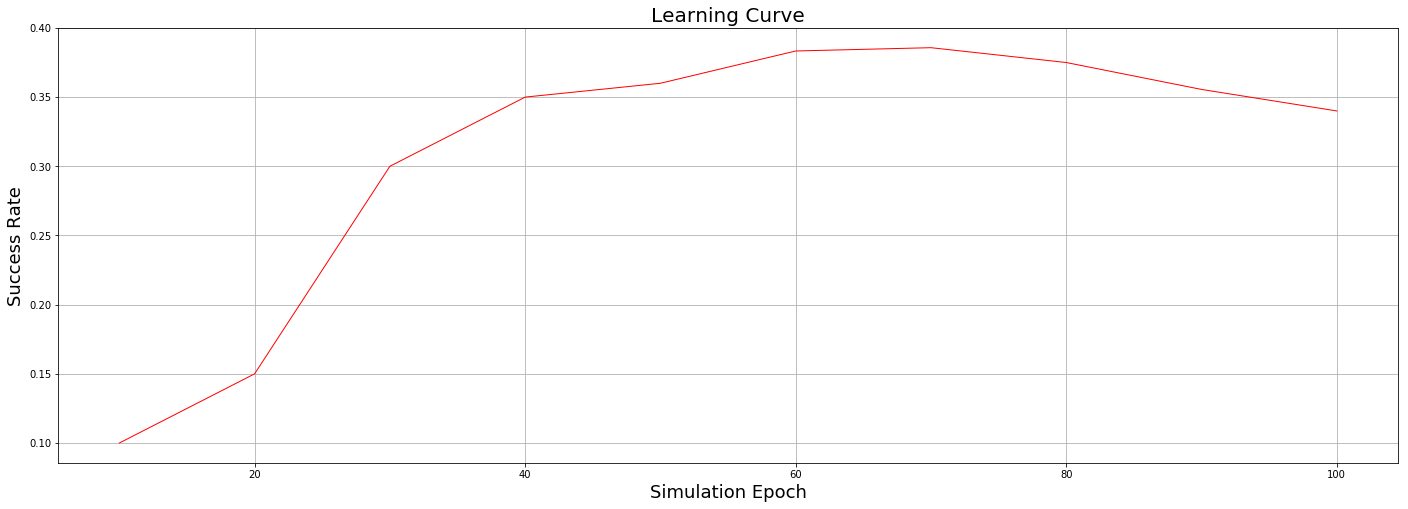

In [606]:
draw_learning_curve(succ_rates)